In [2]:
import torch
import torch.nn as nn
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast, DistilBertModel
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler
import time, datetime, random, re
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from torch.cuda.amp import autocast, GradScaler
from torch.optim import AdamW
from tqdm.notebook import tqdm

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from operator import itemgetter
from tqdm.notebook import tqdm

import json
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import pickle

SEED = 15
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.cuda.amp.autocast(enabled=True)
device = torch.device("cuda")

2023-05-16 15:03:14.728213: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-16 15:03:15.226352: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Tokens prep

In [3]:
physics = {'quant-ph', 'physics', 'nucl-th', 'nucl-ex', 'nlin', 
           'math-ph', 'hep-th', 'hep-ph', 'hep-lat', 'hep-ex', 
           'gr-qc', 'cond-mat', 'astro-ph', 'adap-org', 'physics'}

tags_names = {
    'cs': 'Computer Science',
    'econ': 'Economics',
    'eess': 'Electrical Engineering and Systems Science',
    'math': 'Mathematics',
    'physics': 'Physics',
    'q-bio': 'Quantitative Biology',
    'q-fin': 'Quantitative Finance',
    'stat': 'Statistics',
}

def get_cat(tag):
    # returns tag category as number / -1 if unkown
    tag = tag.split('.')[0]
    if tag in physics:
        return "physics"
    return tag

def remove_mul_spaces(text):
    return re.sub(r"\s+", " ", text)

def try_remove(lst, val):
    try:
        lst.remove(val)
    except ValueError:
        pass
    return lst

In [4]:
# with open('./data/papers_merged.pickle', 'rb') as f:
#     fetched_data = pickle.load(f)

# data = pd.DataFrame([{'title': remove_mul_spaces(paper['title']),
#                       'summary': remove_mul_spaces(paper['summary']),
#                       'category': get_cat(paper['arxiv_primary_category']['term']),
#                       'sub_cat_main': paper['arxiv_primary_category']['term'],
#                       'sub_cat_other': [tag['term'] for tag in paper['tags'] if get_cat(tag['term']) in tags_names]
#                     } for paper in fetched_data])

# cat = pd.Categorical(data.category)
# data = data\
#     .drop(columns=['category'])\
#     .assign(category=cat.codes)

# goal_num = 7_000
# num_samples = {cat : min(num, goal_num) for cat, num in data.category.value_counts().reset_index().values}
# data1, _ = RandomUnderSampler(sampling_strategy=num_samples)\
#     .fit_resample(data, data.category)


# sub_cats_count = data1.sub_cat_main.value_counts()
# used_subcats = sub_cats_count[sub_cats_count > 100].index

# sub_cat_ = data1.sub_cat_main
# data1.sub_cat_main = sub_cat_.where(sub_cat_.isin(used_subcats), sub_cat_.apply(get_cat))

# sub_cat = pd.Categorical(data1.sub_cat_main)

# data2 = data1\
#     .drop(columns=['sub_cat_main'])\
#     .assign(sub_cat_main=sub_cat.codes)

# sub_cat_to_num = {category: i for i, category in enumerate(sub_cat.categories)}
# data2.sub_cat_other = data2.sub_cat_other.apply(
#     lambda cats: [sub_cat_to_num[cat] for cat in cats if cat in sub_cat_to_num]
# )

# list(map(try_remove, data2.sub_cat_other, data2.sub_cat_main));

# train_data, val_data = train_test_split(data2, test_size=.1, stratify=data1.category)

# shuffled = np.arange(len(train_data))
# np.random.shuffle(shuffled)
# train_data = train_data.iloc[shuffled]

# with open('./data/cat_data.pickle', 'wb') as f:
#     pickle.dump({"cat" : cat.categories, "subcat" : sub_cat.categories}, f)

In [5]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english')
MAX_LENGTH = 290
MAX_LENGTH_FIELD = 260

def batch_encode(tokenizer, df, return_tensors='pt', batch_size=256, main_cat_weight=5):
    # return list of batches (input_ids, attention_mask) and list of batches of y
    title, summ = df.title.to_list(), df.summary.to_list()
    total = df.title.str.cat([pd.Series(tokenizer.sep_token, index=df.index), df.summary]).to_list()
    
    y = np.zeros((len(df), len(sub_cat.categories)))
    subs = [np.array(sub_cats, dtype=int) for sub_cats in df.sub_cat_other]
    y[np.repeat(np.arange(len(y)), list(map(len, subs))), np.concatenate(subs)] = 1
    y[np.arange(len(y)), df.sub_cat_main] = np.array(list(map(len, subs)))*2 + 1
    y /= y.sum(axis=1, keepdims=True)
    
    encoded = []
    ys = []
    getter = itemgetter('input_ids', 'attention_mask')
    
    for i in tqdm(range(0, len(title), batch_size)):
        slice_ = slice(i, i + batch_size)
        batch_t = title[slice_]
        batch_s = summ[slice_]
        batch_total = total[slice_]
        
        inputs = []
        for batch, max_length  in [(batch_t, MAX_LENGTH_FIELD),
                                   (batch_s, MAX_LENGTH_FIELD),
                                   (batch_total, MAX_LENGTH)]:
            inputs.append(getter(tokenizer.batch_encode_plus(
                batch,
                max_length=max_length,
                padding='longest',
                truncation=True,
                return_attention_mask=True,
                return_token_type_ids=False,
                return_tensors=return_tensors
            )))
        
        encoded.append(inputs)
        ys.append(torch.tensor(y[slice_]))
    
    return encoded, ys

In [6]:
# train_seq, val_seq = (batch_encode(tokenizer, df, batch_size=32) for df in [train_data, val_data])

In [7]:
# import pickle

# with open('./data/encoded.pickle', 'wb+') as f:
#     pickle.dump({'train': train_seq, 'val': val_seq}, f)

In [8]:
with open('./data/encoded.pickle', 'rb') as f:
    pickle_obj = pickle.load(f)
train_seq, val_seq = pickle_obj['train'], pickle_obj['val']

In [9]:
from pathlib import Path

with open('./data/cat_data.pickle', 'rb') as f:
    SUB_CATEGORIES_NUM = len(pickle.load(f)["subcat"])

class MyModel(nn.Module):
    def __init__(self, path=None, n_labels=SUB_CATEGORIES_NUM):
        super().__init__()
        self.transformer = None
        if path is None:
            self.transformer = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.clf = nn.Sequential(
            nn.Linear(in_features=768, out_features=2048),
            nn.ReLU(),
            torch.nn.BatchNorm1d(num_features=2048),
            nn.Dropout(.2),
            nn.Linear(in_features=2048, out_features=2048),
            nn.ReLU(),
            torch.nn.BatchNorm1d(num_features=2048),
            nn.Dropout(.2),
            nn.ReLU(),
            nn.Linear(in_features=2048, out_features=2048),
            nn.ReLU(),
            torch.nn.BatchNorm1d(num_features=2048),
            nn.Dropout(.2),
            nn.ReLU(),
            nn.Linear(in_features=2048, out_features=1024),
            torch.nn.BatchNorm1d(num_features=1024),
            nn.Dropout(.2),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=n_labels),
        )
        
        if path is not None:
            self.load(path)
    
    def forward(self, input_ids, attention_mask):
        X = self.transformer(input_ids=input_ids, attention_mask=attention_mask)[0][:, 0]
        return self.clf(X)
    
    def save(self, path):
        path = Path(path)
        if not path.exists():
            path.mkdir()
        for i, layer in enumerate([self.clf]):
            torch.save(layer.state_dict(), path / f"layer_{i}.pt")
        self.transformer.save_pretrained(path / "transformer-chkp")
        
    def load(self, path):
        path = Path(path)
        self.transformer = DistilBertModel.from_pretrained(
            path / "transformer-chkp",
            local_files_only=True
        )
        for i, layer in enumerate([self.clf]):
            layer.load_state_dict(torch.load(path / f"layer_{i}.pt"))

In [66]:
from torch.utils.data import Dataset, DataLoader
import numpy as np
from random import shuffle
from collections import defaultdict

class MyDataset(Dataset):
    def __init__(self, seq, epoch_size=None):
        super().__init__()
        self.X, self.y = seq
        self.epoch_size = epoch_size or len(self.X)

    def __len__(self):
        return self.epoch_size

    def __getitem__(self, idx):
        if idx >= self.epoch_size:
            raise IndexError
        return self.X[idx], self.y[idx]
    
    def reshuffle(self):
        zipped = list(zip(self.X, self.y))
        shuffle(zipped)
        self.X, self.y = zip(*zipped)

def get_prediction(logits_on_gpu):
    return logits_on_gpu.argmax(axis=1).flatten().detach().cpu().numpy()

class ExpMean:
    def __init__(self, alpha=.95):
        # the greater alpha, the lesser influence for new
        self.val = None
        self.alpha = alpha
    
    def upd(self, new_val):
        if self.val is None:
            self.val = new_val
        else:
            self.val = self.val * self.alpha + new_val * (1 - self.alpha)
    
    def __repr__(self):
        return str(self.val)

def calc_metrics(logits, y_true_cpu, name, metrics, counter, metrics_exp=None):
    y_pred = get_prediction(logits)
    new_acc = accuracy_score(get_prediction(y_true_cpu), y_pred)
    metrics[f'accuracy_{name}'] += new_acc
    counter[f'accuracy_{name}'] += 1
    
    if metrics_exp is not None:
        metrics_exp[f'accuracy_{name}'].upd(new_acc)
    
def train(model, dataloader, optimizer, scaler, loss_fn, scheduler, exp_mean_alpha = .8, proba=None):
    # param proba: list of length 2 - probabilities to select only title, only summary.
    #    probability to select both is 1 - sum(proba)
    # the greater exp_mean_alpha, the lesser influence of new means
    if proba is None:
        proba = [0.2, 0.2]
    proba.append(1 - sum(proba))
    proba = np.array(proba)
    
    metrics = defaultdict(float)
    counter = defaultdict(int)
    metrics_exp = defaultdict(lambda: ExpMean(exp_mean_alpha))

    model.train()
    
    dataloader.reshuffle()
    pbar = tqdm(dataloader)
    cur_acc = None
    
    for X_, y_true in pbar:
        # idx = np.random.choice(3, p=proba)
        for name, X in zip(['title_only', 'summ_only', 'both'], X_):
            X = [x.to(device) for x in X]
            y_true_cpu = y_true
            y_true = y_true.to(device)

            optimizer.zero_grad()
            with autocast():
                logits = model(*X)
        
            loss = loss_fn(logits, y_true)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            metrics[f'loss_{name}'] += loss.item()
            counter[f'loss_{name}'] += 1
            with torch.no_grad():
                calc_metrics(logits, y_true_cpu, name, metrics, counter, metrics_exp)
        scheduler.step()
        
            
        pbar.set_description(" ".join(f'{metric}: {acc.val:.4f}' for metric, acc in metrics_exp.items()))
        
    for metric in metrics:
        try:
            metrics[metric] /= counter[metric]
        except ZeroDivisionError:
            pass
    
    torch.cuda.empty_cache()
    
    return metrics

def validate(model, dataloader, loss_fn, **kwargs):
    model.eval()

    metrics = defaultdict(float)
    counter = defaultdict(int)
    
    dataloader.reshuffle()
    pbar = tqdm(dataloader)
    for X_, y_true in pbar:
        y_true_cpu = y_true
        y_true = y_true.to(device)  
                                        
        with torch.no_grad():
            for name, X in zip(['title_only', 'summ_only', 'both'], X_):
                X = [x.to(device) for x in X]
                logits = model(*X)
                loss = loss_fn(logits, y_true)
                metrics[f'loss_{name}'] += loss.item()
                counter[f'loss_{name}'] += 1
                calc_metrics(logits, y_true_cpu, name, metrics, counter)
                if name == 'both':
                    # proba = logits.detach().cpu().softmax(dim=-1)
                    # cat_pred = torch.vstack([proba[:, val].sum(dim=-1) for val in cat_nums.values()]).T.argmax(dim=-1)
                    metrics['cat_acc'] += accuracy_score(
                        list(map(subcat_to_cat.get, get_prediction(y_true_cpu))),
                        list(map(subcat_to_cat.get, get_prediction(logits)))
                    )
                    counter['cat_acc'] += 1
                    pbar.set_description(f"acc on both: {metrics['accuracy_both'] / counter['accuracy_both']:.3f}")
                
    for metric in metrics:
        metrics[metric] /= counter[metric]

    torch.cuda.empty_cache()
    return metrics

In [70]:
val_set[0]

([(tensor([[  101,  3116, 12353,  1998, 18678,  2791,  1024,  2312,  1011,  4094,
            10903,  1010,  8720,  1997,  3145,  2838,  1010,  1998, 17547,  1999,
             2613,  1011,  2088,  6556,  6295,   102],
           [  101,  1996, 26553,  4779,  7709,  2007,  4298, 21770, 10624,  6914,
            14769, 23284,  2015,   102,     0,     0,     0,     0,     0,     0,
                0,     0,     0,     0,     0,     0],
           [  101,  2006,  2019,  5331,  1997,  1996, 13017,  4939,  1011, 11545,
             2368,  2944,  1024,  1996,  3896,  1997,  1037, 24004, 21850,  2135,
             1011,  2241,  3747,  8185,   102,     0],
           [  101,  8790,  3973, 12238,  6118, 24110, 23355, 10496,  3665,  1999,
            12441, 20393,  1011,  2732,  7660,   102,     0,     0,     0,     0,
                0,     0,     0,     0,     0,     0],
           [  101,  2128,  9331,  1996, 11203,  2006,  3796, 24925,  2078,  1024,
             1037,  5002,  1997, 10750,  7

In [75]:
model_cpu = model.to('cpu')

In [67]:
validate(model, val_set, **params)

  0%|          | 0/78 [00:00<?, ?it/s]

defaultdict(float,
            {'loss_title_only': 2.346293278008424,
             'accuracy_title_only': 0.41225961538461536,
             'loss_summ_only': 1.8933389315031708,
             'accuracy_summ_only': 0.5168269230769231,
             'loss_both': 1.8730202017681974,
             'accuracy_both': 0.5208333333333334,
             'cat_acc': 0.7395833333333334})

In [11]:
import warnings
from IPython.display import clear_output
from plotly.subplots import make_subplots
import plotly.express as px
import pandas as pd
import numpy as np
from math import ceil

warnings.filterwarnings('ignore')

def plot_series(dfs_arr, titles, height=600, width=1000, plot_cols=3, path=None):
    plot_rows = ceil(len(dfs_arr) / plot_cols)
    fig = make_subplots(rows=plot_rows, cols=plot_cols, subplot_titles=titles)

    # add traces
    i, j = 1, 1
    for df in dfs_arr:
        for trace in px.line(df, x="epoch", y="value", color="stage")["data"]:
            fig.append_trace(
                trace,
                row=i, col=j
            )
        j += 1
        if j > plot_cols:
            j = 1
            i += 1
    fig.update_layout(height=height, width=width, showlegend=True)
    fig.show()
    if path is not None:
        fig.write_image(path)

def plot(acc_history, metrics, path=None):
    if len(acc_history['train']) > 1:
        dfs = []
        for metric in metrics:
            acc_history = {stage : pd.DataFrame(df) for stage, df in acc_history.items()}
            dfs.append(pd.concat(
                pd.DataFrame({'value': df[metric], 'epoch': list(df.index + 1), 'stage': stage})
                for stage, df in acc_history.items()
            ))
        plot_series(dfs, metrics, path=path)
    else:
        print(acc_history)
        

In [12]:
samples_per_epoch = 400
val_samples = len(val_seq[0]) // 2

epochs = 20
train_set = MyDataset(train_seq, samples_per_epoch)
val_set = MyDataset(val_seq, val_samples)
model = MyModel()
loss_fn = torch.nn.CrossEntropyLoss()
model.cuda()

optimizer = AdamW(model.parameters(),
                  lr=2e-6,
                  weight_decay=0.65
                )

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=len(train_set) * epochs)

acc_history = {'train': [], 'val': []}
params = dict(
    optimizer=optimizer,
    scaler=GradScaler(),
    scheduler=scheduler,
    loss_fn=loss_fn,
    exp_mean_alpha=0.95
)
max_acc = 0.

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


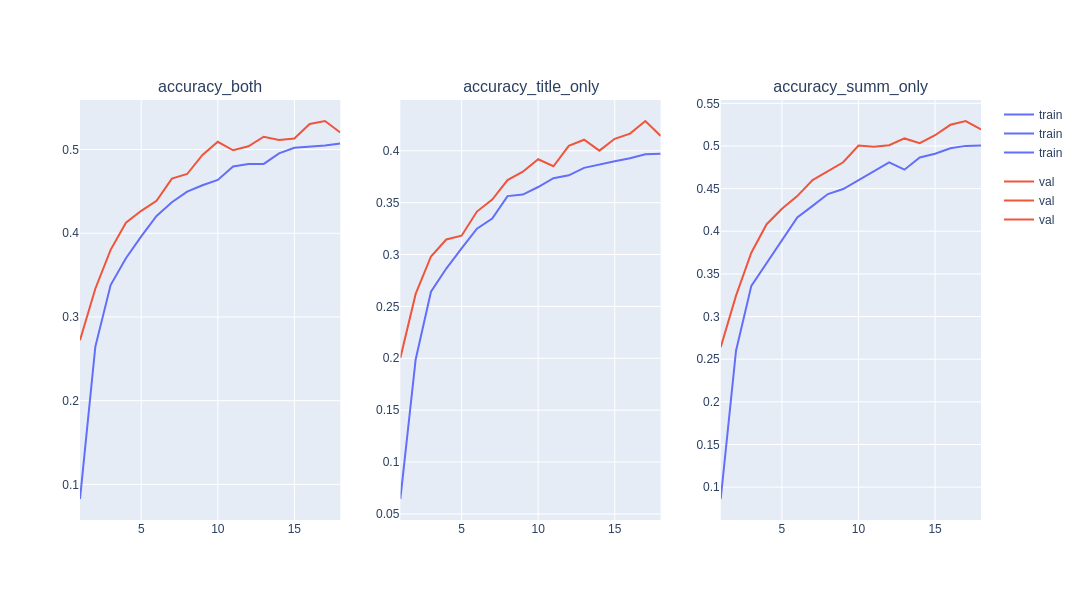

  0%|          | 0/400 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [14]:
for _ in range(epochs):
    clear_output(True)
    plot(acc_history, ["accuracy_both", "accuracy_title_only", "accuracy_summ_only"], f"plots/model_07.2.png")

    acc_history['train'].append(train(model, train_set, **params))
    acc_history['val'].append(validate(model, val_set, **params))
    if acc_history['val'][-1]['accuracy_total'] > max_acc:
        max_acc = acc_history['val'][-1]['accuracy_total']
        model.save(f'./models/07.2')

In [50]:
def validate(model, dataloader):
    model.eval()

    acc = 0
    pbar = tqdm(dataloader)
    y_pred = []
    y_true_list = []
    for X_, y_true in pbar:
        y_true_cpu = y_true
        y_true = y_true.to(device)
                                        
        with torch.no_grad():
            X = X_[-1]
            X = [x.to(device) for x in X]
            logits = model(*X)
            proba_ = logits.softmax(dim=-1)
            
            for proba in proba_:
                prob_sum = defaultdict(float)
                for i, prob in enumerate(proba):
                    prob_sum[get_cat(num_to_sub_cat[i])] += prob.item()
                y_pred.append(cat_to_num[max(prob_sum, key=prob_sum.get)])
            y_true_list.append(
                np.array([cat_to_num[get_cat(num_to_sub_cat[t])] for t in get_prediction(y_true)]))
    return y_pred, y_true_list

In [15]:
import pickle
from collections import defaultdict

with open('./data/cat_data.pickle', 'rb') as f:
    cat_data = pickle.load(f)
    cats, sub_cats = cat_data["cat"], cat_data["subcat"]
    
cats = list(cats)
subcat_to_cat = {}
cat_nums = defaultdict(list)
for cat_num, sub_cat in enumerate(sub_cats):
    cat_idx = cats.index(get_cat(sub_cat))
    cat_nums[cat_idx].append(cat_num)
    subcat_to_cat[cat_num] = cat_idx

In [ ]:
def validate(model, dataloader, loss_fn, **kwargs):
    model.eval()

    metrics = defaultdict(float)
    counter = defaultdict(int)
    
    dataloader.reshuffle()
    pbar = tqdm(dataloader)
    for X_, y_true in pbar:
        y_true_cpu = y_true
        y_true = y_true.to(device)  
                                        
        with torch.no_grad():
            for name, X in zip(['title_only', 'summ_only', 'both'], X_):
                X = [x.to(device) for x in X]
                logits = model(*X)
                loss = loss_fn(logits, y_true)
                metrics[f'loss_{name}'] += loss.item()
                counter[f'loss_{name}'] += 1
                calc_metrics(logits, y_true_cpu, name, metrics, counter)
                if name == 'both':
                    pbar.set_description(f"acc on both: {metrics['accuracy_both'] / counter['accuracy_both']:.3f}")
                    logits = logtits.detach().cpu()
                    cat_pred = torch.vstack(logits[:, val].sum(dim=-1) for val in cat_nums.values()).T.argmax(dim=-1)
                    metrics['cat_acc'] += accuracy_score(
                        list(map(subcat_to_cat.get, get_prediction(y_true_cpu))),
                        cat_pred
                    )
                    counter['cat_acc'] += 1
                
    for metric in metrics:
        metrics[metric] /= counter[metric]

    torch.cuda.empty_cache()
    return metrics

In [51]:
val_set = MyDataset(val_seq)

In [52]:
t, tt = validate(model, val_set)

  0%|          | 0/157 [00:00<?, ?it/s]

In [57]:
accuracy_score(t, np.concatenate(tt))

0.7334533093381324